# Company 1: BRUKER CORP -  ML Process

Decision to go with a logistic regression, predicting whether the share price will increase or decrease, based on the share prices of the past 4 days.

This notebook is organized in the following sections:
* [Step 0 - Preliminary: Load the clean csv](#0)
* [Step 1 - Remodel dataset](#1)
* [Step 2 - Model Training](#2)
* [Step 3 - Model Evaluation](#3)



<a id='0'></a>
## Step 0 - Preliminary: Load the clean csv

In [82]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

In [83]:
prices = pd.read_csv("/Users/camillaperotti/Desktop/IE/Courses MBD/Term 2/PDA II/00_GroupProject/mbd-python-tradingsystem/ETL/prices_output.csv")

In [84]:
prices.drop(columns=['Unnamed: 0'], inplace=True)

In [85]:
prices

,Ticker,SimFinId,Date,Open,High,Low,Close,Adj. Close,Volume,Dividend,Shares Outstanding
0,AAPL,111052,2019-04-01,47.91,47.92,47.09,47.81,45.81,111447856,0.0,18429136000
1,AAPL,111052,2019-04-02,47.77,48.62,47.76,48.51,46.47,91062928,0.0,18429136000
2,AAPL,111052,2019-04-03,48.31,49.12,48.29,48.84,46.79,93087320,0.0,18429136000
3,AAPL,111052,2019-04-04,48.70,49.09,48.28,48.92,46.87,76457100,0.0,18429136000
4,AAPL,111052,2019-04-05,49.11,49.27,48.98,49.25,47.19,74106576,0.0,18429136000
...,...,...,...,...,...,...,...,...,...,...,...
6190,TSLA,56317,2024-02-26,192.29,201.78,192.00,199.40,199.40,111747116,0.0,3184790415
6191,TSLA,56317,2024-02-27,204.04,205.60,198.26,199.73,199.73,108645412,0.0,3184790415
6192,TSLA,56317,2024-02-28,200.42,205.30,198.44,202.04,202.04,99806173,0.0,3184790415
6193,TSLA,56317,2024-02-29,204.18,205.28,198.45,201.88,201.88,85906974,0.0,3184790415


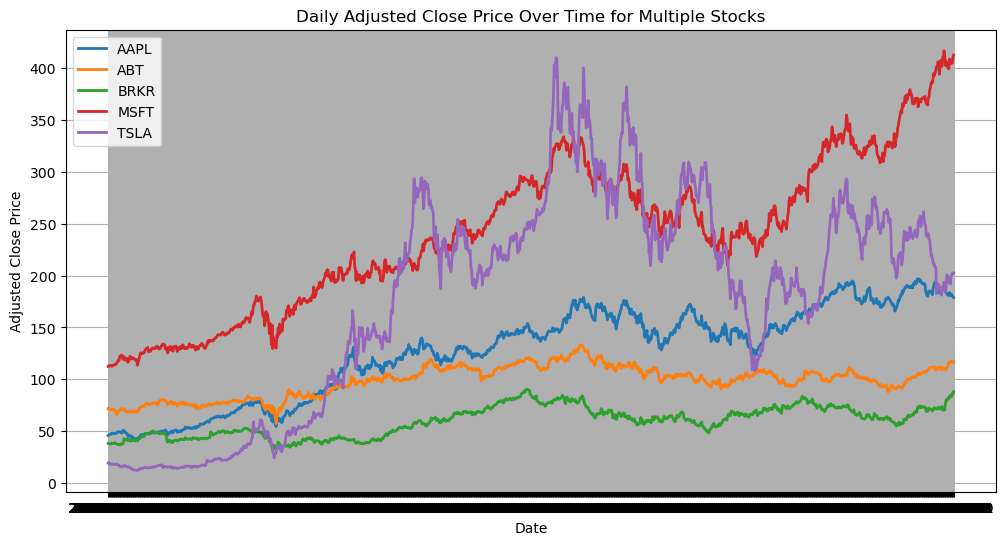

In [86]:
plt.figure(figsize=(12, 6))

# Assuming the DataFrame has columns: 'Date', 'Symbol', and 'Adj. Close'
for symbol in prices['Ticker'].unique():
    stock_data = prices[prices['Ticker'] == symbol]
    plt.plot(stock_data['Date'], stock_data['Adj. Close'], label=symbol, linewidth=2)

plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.title('Daily Adjusted Close Price Over Time for Multiple Stocks')
plt.legend()
plt.grid(True)
plt.show()

<a id='1'></a>
## Step 1 - Dataset preparation

We will work only with prices of the last 5 days to predict 

In [87]:
# Ensure data is sorted by date
prices.sort_values(by=["Ticker", "Date"], inplace=True) 
prices.reset_index(drop=True, inplace=True) 

# Drop all unwanted columns
prices.drop(columns=["SimFinId","Open","High", "Low", "Close", "Volume", "Dividend","Shares Outstanding"],inplace = True)

# Rename adjusted close column

prices.rename(columns={"Adj. Close": "Price"}, inplace= True)

Let's add the last 4 days' prices into the df:

In [88]:
days = 4

# Apply shift only within each stock ticker
for day in range(1, days + 1):
    prices[f"Price d-{day}"] = prices.groupby("Ticker")["Price"].shift(day)


In [89]:
#dropping first rows with missing values

prices.dropna(inplace=True)

In [90]:
prices[prices.Ticker == "AAPL"]

,Ticker,Date,Price,Price d-1,Price d-2,Price d-3,Price d-4
4,AAPL,2019-04-05,47.19,46.87,46.79,46.47,45.81
5,AAPL,2019-04-08,47.93,47.19,46.87,46.79,46.47
6,AAPL,2019-04-09,47.79,47.93,47.19,46.87,46.79
7,AAPL,2019-04-10,48.06,47.79,47.93,47.19,46.87
8,AAPL,2019-04-11,47.66,48.06,47.79,47.93,47.19
...,...,...,...,...,...,...,...
1234,AAPL,2024-02-26,180.31,181.66,183.50,181.46,180.71
1235,AAPL,2024-02-27,181.77,180.31,181.66,183.50,181.46
1236,AAPL,2024-02-28,180.57,181.77,180.31,181.66,183.50
1237,AAPL,2024-02-29,179.90,180.57,181.77,180.31,181.66


In [91]:
prices.iloc[1230:1250]

,Ticker,Date,Price,Price d-1,Price d-2,Price d-3,Price d-4
1234,AAPL,2024-02-26,180.31,181.66,183.50,181.46,180.71
1235,AAPL,2024-02-27,181.77,180.31,181.66,183.50,181.46
1236,AAPL,2024-02-28,180.57,181.77,180.31,181.66,183.50
1237,AAPL,2024-02-29,179.90,180.57,181.77,180.31,181.66
1238,AAPL,2024-03-01,178.82,179.90,180.57,181.77,180.31
1243,ABT,2019-04-05,71.18,70.83,71.63,71.73,71.77
1244,ABT,2019-04-08,70.74,71.18,70.83,71.63,71.73
1245,ABT,2019-04-09,70.88,70.74,71.18,70.83,71.63
1246,ABT,2019-04-10,71.15,70.88,70.74,71.18,70.83
1247,ABT,2019-04-11,70.73,71.15,70.88,70.74,71.18


Add the target variable (1: tomorrow's price goes up, 0: price goes down or stays the same):

In [92]:
prices["Price_Up"] = (prices["Price"].shift(-1) > prices["Price"]).astype(int)

In [93]:
prices

,Ticker,Date,Price,Price d-1,Price d-2,Price d-3,Price d-4,Price_Up
4,AAPL,2019-04-05,47.19,46.87,46.79,46.47,45.81,1
5,AAPL,2019-04-08,47.93,47.19,46.87,46.79,46.47,0
6,AAPL,2019-04-09,47.79,47.93,47.19,46.87,46.79,1
7,AAPL,2019-04-10,48.06,47.79,47.93,47.19,46.87,0
8,AAPL,2019-04-11,47.66,48.06,47.79,47.93,47.19,0
...,...,...,...,...,...,...,...,...
6190,TSLA,2024-02-26,199.40,191.97,197.41,194.77,193.76,1
6191,TSLA,2024-02-27,199.73,199.40,191.97,197.41,194.77,1
6192,TSLA,2024-02-28,202.04,199.73,199.40,191.97,197.41,0
6193,TSLA,2024-02-29,201.88,202.04,199.73,199.40,191.97,1


Dropping last row of each stock as it has no "next day" to compare to:

In [94]:
# Identify the last row of each Ticker group
last_rows = prices.groupby("Ticker").tail(1).index

# Drop these rows
prices = prices.drop(index=last_rows)
#.reset_index(drop=True)

The dataset is now ready to be used for the logistic regression.

Check if dataset is balanced:

In [98]:
prices["Price_Up"].value_counts() / len(prices)

Price_Up
1    0.526742
0    0.473258
Name: count, dtype: float64

Conclusion: The dataset is balanced. Separate features from the target:
- Features: all prices of last 5 days
- Target variable: Prediction if price will rise (1) or fall / remain the same (0)

In [113]:
x = prices_bruker.drop(columns=["Price_Up", "Date"])
y = prices_bruker["Price_Up"]

In [114]:
x

,Price,Price d-1,Price d-2,Price d-3,Price d-4
4,37.74,37.66,38.33,37.86,38.20
5,38.16,37.74,37.66,38.33,37.86
6,37.98,38.16,37.74,37.66,38.33
7,38.33,37.98,38.16,37.74,37.66
8,38.41,38.33,37.98,38.16,37.74
...,...,...,...,...,...
1233,84.42,83.49,81.68,80.86,81.58
1234,83.35,84.42,83.49,81.68,80.86
1235,83.45,83.35,84.42,83.49,81.68
1236,86.23,83.45,83.35,84.42,83.49


Split data into training and testing set:

In [115]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

Scale the features (x):

In [116]:
sc = StandardScaler()
x_train_scaled = sc.fit_transform(x_train)
x_test_scaled = sc.transform(x_test)

<a id='2'></a>
## Step 2 - Model Training

Fitting Logistic Regression to the Training set:

In [117]:
classifier = LogisticRegression(random_state = 1)
classifier.fit(x_train_scaled, y_train)

LogisticRegression(random_state=1)

Save the model and scaler:

In [118]:
import joblib

# Define file paths
model_path = "/Users/camillaperotti/Desktop/IE/Courses MBD/Term 2/PDA II/00_GroupProject/mbd-python-tradingsystem/Scripts/models/model.pkl"
scaler_path = "/Users/camillaperotti/Desktop/IE/Courses MBD/Term 2/PDA II/00_GroupProject/mbd-python-tradingsystem/Scripts/models/scaler.pkl"

# Save trained model
joblib.dump(classifier, model_path)
print(f"Model saved at {model_path}")

# Save scaler
joblib.dump(sc, scaler_path)
print(f"Scaler saved at {scaler_path}")


Model saved at /Users/camillaperotti/Desktop/IE/Courses MBD/Term 2/PDA II/00_GroupProject/mbd-python-tradingsystem/Scripts/models/model.pkl
Scaler saved at /Users/camillaperotti/Desktop/IE/Courses MBD/Term 2/PDA II/00_GroupProject/mbd-python-tradingsystem/Scripts/models/scaler.pkl


Load model again to only train once:

In [119]:
classifier = joblib.load(model_path)
sc = joblib.load(scaler_path)

<a id='3'></a>
## Step 3 - Model Evaluation

Predict on testing:

In [120]:
#now we want to see the predictions for the testing
y_predict_test = classifier.predict(x_test_scaled)
y_predict_test

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1])

In [121]:
#confusion matrix for testing data
#cm = confusion_matrix(y_test, y_predict_test)
#sns.heatmap(cm, annot=True, fmt="d")

In [122]:
#look at the performance evaluators for testing data
from sklearn.metrics import classification_report
print(classification_report(y_test, y_predict_test))


              precision    recall  f1-score   support

           0       0.55      0.16      0.24       115
           1       0.55      0.89      0.68       132

    accuracy                           0.55       247
   macro avg       0.55      0.52      0.46       247
weighted avg       0.55      0.55      0.47       247



Predict next days's movement:

In [123]:
print("Latest features used in ML.ipynb:", x.iloc[-1:])

Latest features used in ML.ipynb:       Price  Price d-1  Price d-2  Price d-3  Price d-4
1237  86.33      86.23      83.45      83.35      84.42


In [130]:
# Get the latest available row
latest_features = x.iloc[-1:] # Last row
latest_features_scaled = sc.transform(latest_features)  # Scale it

# Predict
next_day_prediction = classifier.predict(latest_features_scaled)
print("Next day's price will go:", "UP" if next_day_prediction[0] == 1 else "DOWN")


Next day's price will go: DOWN


In [125]:
latest_features_scaled

array([[1.88823862, 1.88443381, 1.69412325, 1.6932147 , 1.77720541]])

In [126]:
latest_features

array([[86.33, 86.23, 83.45, 83.35, 84.42]])

In [127]:
next_day_prediction

array([0])